### Due to computational limitations from google colab, we illustrate the training and testing of a network on CMC maps using a simplify version of the benchmark codes and also using a fraction of all the data available. We note that the results obtained in this example are far from optimal and are just shown as an illustration.

### Import libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import time, sys, os
import matplotlib.pyplot as plt
import optuna
from sklearn.metrics import r2_score
from dataloader import create_dataset_multifield
from models import model_o3_err, model_o3_err_1param, model_o3_err_cosmology

### The code will run on both CPUs or GPUs

In [2]:
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')
cudnn.benchmark = True      #May train faster but cost more memory

CUDA Available


### Define the value of the parameters and hyperparameters

In [3]:
# data parameters
fmaps      = ['maps_T.npy'] #tuple containing the maps with the different fields to consider
fmaps_norm = ['maps_T.npy'] #if you want to normalize the maps according to the properties of some data set, put that data set here (This is mostly used when training on IllustrisTNG and testing on SIMBA, or vicerversa)
seed       = 1   #random seed to split maps among training, validation and testing
splits     = 15   #number of maps per simulation

# training parameters
channels        = 1                #we only consider here 1 field
# params          = [0,1,2,3,4,5]    #0(Omega_m) 1(sigma_8) 2(A_SN1) 3 (A_AGN1) 4(A_SN2) 5(A_AGN2). The code will be trained to predict all these parameters.
params          = [0,1]
# params          = [0]
g               = params           #g will contain the mean of the posterior
# h               = [6+i for i in g] #h will contain the variance of the posterior
h               = [2+i for i in g] #h will contain the variance of the posterior
# h               = [1+i for i in g] #h will contain the variance of the posterior
# rot_flip_in_mem = True             #whether rotations and flipings are kept in memory. True will make the code faster but consumes more RAM memory.
rot_flip_in_mem = True

# optimizer parameters
beta1 = 0.5
beta2 = 0.999

# hyperparameters
batch_size = 128
min_lr     = 1e-9
max_lr     = 0.0036  # default: 1e-3
wd         = 0.0258  #value of weight decay, default: 0.0005
dr         = 0.4     #dropout value for fully connected layers, default: 0.2
hidden     = 11       #this determines the number of channels in the CNNs; integer larger than 1, default: 5
epochs     = 200      #number of epochs to train the network

# output files names
output_dir = 'layer20_TNG_2param_norm'
os.makedirs(output_dir, exist_ok=True)
floss  = os.path.join(output_dir, 'loss.txt')   #file with the training and validation losses for each epoch
fmodel = os.path.join(output_dir, 'weights.pt') #file containing the weights of the best-model

### load data

In [4]:
# TNG - 43

# data
fparams = '2D_maps/data/params_LH_IllustrisTNG.txt'
fmaps2 = '2D_maps/data/Maps_T_IllustrisTNG_LH_z=0.00.npy'

# params
# fdatabase  = 'sqlite:///2D_maps/inference/databases/IllustrisTNG_o3_T_all_steps_500_500_o3.db'
# study_name = 'wd_dr_hidden_lr_o3'
# study = optuna.load_study(study_name=study_name, storage=fdatabase)
# trial_number = 43
# trial = study.trials[trial_number]
# hidden, dr = trial.params['hidden'], trial.params['dr']

# weights
fweights = '2D_maps/inference/weights/weights_IllustrisTNG_T_43_all_steps_500_500_o3.pt'

# load data
maps  = np.load(fmaps2)
np.save('maps_T.npy', maps)
print('Shape of the maps:', maps.shape)
del maps

Shape of the maps: (15000, 256, 256)


In [14]:
# SIMBA - 37

# data
fparams = '2D_maps/data/params_LH_SIMBA.txt'
fmaps2 = '2D_maps/data/Maps_T_SIMBA_LH_z=0.00.npy'

# params
# fdatabase  = 'sqlite:///2D_maps/inference/databases/SIMBA_o3_T_all_steps_500_500_o3.db'
# study_name = 'wd_dr_hidden_lr_o3'
# study = optuna.load_study(study_name=study_name, storage=fdatabase)
# trial_number = 37
# trial = study.trials[trial_number]
# hidden, dr = trial.params['hidden'], trial.params['dr']

# weights
fweights = '2D_maps/inference/weights/weights_SIMBA_T_37_all_steps_500_500_o3.pt'

# load data
maps  = np.load(fmaps2)
np.save('maps_T.npy', maps)
print('Shape of the maps:', maps.shape)
del maps

Shape of the maps: (15000, 256, 256)


In [4]:
# TNG + SIMBA

# data
fmaps2_TNG = '2D_maps/data/Maps_T_IllustrisTNG_LH_z=0.00.npy'
fmaps2_SIMBA = '2D_maps/data/Maps_T_SIMBA_LH_z=0.00.npy'

fparams = '2D_maps/data/params_LH.txt'

# load data
maps_TNG = np.load(fmaps2_TNG)
maps_SIMBA = np.load(fmaps2_SIMBA)
maps = np.concatenate((maps_TNG, maps_SIMBA), axis=0)
np.save('maps_T.npy', maps)
print('Shape of the maps:', maps.shape)
del maps

Shape of the maps: (30000, 256, 256)


In [5]:
# get training set
print('\nPreparing training set')
train_loader = create_dataset_multifield('train', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                         rot_flip_in_mem=rot_flip_in_mem, verbose=True)

# get validation set
print('\nPreparing validation set')
valid_loader = create_dataset_multifield('valid', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                         rot_flip_in_mem=True,  verbose=True)


Preparing training set
Found 1 channels
Reading data...
1.502e+03 < F(all|orig) < 8.669e+07
3.177 < F(all|resc)  < 7.938
-1.282 < F(all|norm) < 4.550
Channel 0 contains 108000 maps
-1.282 < F < 4.550


Preparing validation set
Found 1 channels
Reading data...
1.502e+03 < F(all|orig) < 8.669e+07
3.177 < F(all|resc)  < 7.938
-1.282 < F(all|norm) < 4.550
Channel 0 contains 6000 maps
-1.240 < F < 4.189



In [27]:
# now that architecture is defined above, use it
model = model_o3_err_1param(hidden, dr, channels)
model = nn.DataParallel(model)
model.to(device=device)
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

total number of parameters in the model = 28429326


### Define the optimizer & scheduler

In [7]:
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=wd, betas=(beta1, beta2))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=10)

# optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=wd, betas=(beta1, beta2))
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=min_lr, max_lr=max_lr, 
#                                               cycle_momentum=False, step_size_up=500, step_size_down=500)

### compute the initial validation loss

In [8]:
print('Computing initial validation loss')
model.eval()
valid_loss1, valid_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
min_valid_loss, points = 0.0, 0
for x, y in valid_loader:
      with torch.no_grad():
          bs   = x.shape[0]                #batch size
          x    = x.to(device=device)       #maps
          y    = y.to(device=device)[:,g]  #parameters
          p    = model(x)                  #NN output
          y_NN = p[:,g]                    #posterior mean
          e_NN = p[:,h]                    #posterior std
          loss1 = torch.mean((y_NN - y)**2,                axis=0)
          loss2 = torch.mean(((y_NN - y)**2 - e_NN**2)**2, axis=0)
          loss  = torch.mean(torch.log(loss1) + torch.log(loss2))
          valid_loss1 += loss1*bs
          valid_loss2 += loss2*bs
          points += bs
min_valid_loss = torch.log(valid_loss1/points) + torch.log(valid_loss2/points)
min_valid_loss = torch.mean(min_valid_loss).item()
print('Initial valid loss = %.3e'%min_valid_loss)

Computing initial validation loss
Initial valid loss = 3.129e+00


### Now do a loop over all epochs while training and validating

In [9]:
from tqdm import tqdm
# do a loop over all epochs
start = time.time()
for epoch in tqdm(range(epochs)):

    # do training
    train_loss1, train_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
    train_loss, points = 0.0, 0
    model.train()
    for x, y in train_loader:
        bs   = x.shape[0]         #batch size
        x    = x.to(device)       #maps
        y    = y.to(device)[:,g]  #parameters
        p    = model(x)           #NN output
        y_NN = p[:,g]             #posterior mean
        e_NN = p[:,h]             #posterior std
        loss1 = torch.mean((y_NN - y)**2,                axis=0)
        loss2 = torch.mean(((y_NN - y)**2 - e_NN**2)**2, axis=0)
        loss  = torch.mean(torch.log(loss1) + torch.log(loss2))
        train_loss1 += loss1*bs
        train_loss2 += loss2*bs
        points      += bs
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #if points>18000:  break
    train_loss = torch.log(train_loss1/points) + torch.log(train_loss2/points)
    train_loss = torch.mean(train_loss).item()

    # do validation: cosmo alone & all params
    valid_loss1, valid_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
    valid_loss, points = 0.0, 0
    model.eval()
    for x, y in valid_loader:
        with torch.no_grad():
            bs    = x.shape[0]         #batch size
            x     = x.to(device)       #maps
            y     = y.to(device)[:,g]  #parameters
            p     = model(x)           #NN output
            y_NN  = p[:,g]             #posterior mean
            e_NN  = p[:,h]             #posterior std
            loss1 = torch.mean((y_NN - y)**2,                axis=0)
            loss2 = torch.mean(((y_NN - y)**2 - e_NN**2)**2, axis=0)
            loss  = torch.mean(torch.log(loss1) + torch.log(loss2))
            valid_loss1 += loss1*bs
            valid_loss2 += loss2*bs
            points     += bs
    valid_loss = torch.log(valid_loss1/points) + torch.log(valid_loss2/points)
    valid_loss = torch.mean(valid_loss).item()

    scheduler.step(valid_loss)

    # verbose
    print('%03d %.3e %.3e '%(epoch, train_loss, valid_loss), end='')

    # save model if it is better
    if valid_loss<min_valid_loss:
        torch.save(model.state_dict(), fmodel)
        min_valid_loss = valid_loss
        print('(C) ', end='')
    print('')

    # save losses to file
    f = open(floss, 'a')
    f.write('%d %.5e %.5e\n'%(epoch, train_loss, valid_loss))
    f.close()

stop = time.time()
print('Time take (h):', "{:.4f}".format((stop-start)/3600.0))

  0%|          | 1/200 [03:02<10:04:18, 182.20s/it]

000 1.346e+01 -7.454e+00 (C) 
001 -1.083e+01 -8.194e+00 

  1%|          | 2/200 [06:01<9:56:03, 180.62s/it] 

(C) 


  2%|▏         | 3/200 [09:01<9:51:04, 180.02s/it]

002 -1.216e+01 -7.108e+00 


  2%|▏         | 4/200 [12:00<9:47:21, 179.80s/it]

003 -1.263e+01 -8.831e+00 (C) 


  2%|▎         | 5/200 [15:00<9:44:03, 179.71s/it]

004 -1.283e+01 -1.058e+01 (C) 


  3%|▎         | 6/200 [17:59<9:40:46, 179.62s/it]

005 -1.297e+01 -7.936e+00 


  4%|▎         | 7/200 [20:58<9:37:29, 179.53s/it]

006 -1.306e+01 -9.140e+00 


  4%|▍         | 8/200 [23:58<9:34:17, 179.46s/it]

007 -1.321e+01 -8.311e+00 


  4%|▍         | 9/200 [26:57<9:31:07, 179.41s/it]

008 -1.326e+01 -7.781e+00 


  5%|▌         | 10/200 [29:56<9:28:07, 179.41s/it]

009 -1.344e+01 -7.453e+00 


  6%|▌         | 11/200 [32:56<9:25:00, 179.37s/it]

010 -1.350e+01 -6.084e+00 


  6%|▌         | 12/200 [35:55<9:22:08, 179.41s/it]

011 -1.349e+01 -1.080e+01 (C) 


  6%|▋         | 13/200 [38:55<9:19:15, 179.44s/it]

012 -1.358e+01 -1.197e+01 (C) 


  7%|▋         | 14/200 [41:54<9:16:07, 179.40s/it]

013 -1.364e+01 -1.002e+01 


  8%|▊         | 15/200 [44:53<9:13:15, 179.44s/it]

014 -1.366e+01 -1.057e+01 


  8%|▊         | 16/200 [47:53<9:10:06, 179.38s/it]

015 -1.375e+01 -8.035e+00 
016 -1.385e+01 -1.284e+01 

  8%|▊         | 17/200 [50:52<9:07:20, 179.46s/it]

(C) 


  9%|▉         | 18/200 [53:52<9:04:20, 179.45s/it]

017 -1.385e+01 -6.334e+00 


 10%|▉         | 19/200 [56:51<9:01:13, 179.41s/it]

018 -1.395e+01 -1.038e+01 


 10%|█         | 20/200 [59:50<8:58:06, 179.37s/it]

019 -1.389e+01 -8.088e+00 


 10%|█         | 21/200 [1:02:50<8:55:12, 179.40s/it]

020 -1.398e+01 -1.069e+01 


 11%|█         | 22/200 [1:05:49<8:52:16, 179.42s/it]

021 -1.399e+01 -8.339e+00 


 12%|█▏        | 23/200 [1:08:50<8:50:26, 179.81s/it]

022 -1.407e+01 -8.867e+00 


 12%|█▏        | 24/200 [1:11:49<8:47:02, 179.67s/it]

023 -1.406e+01 -1.120e+01 


 12%|█▎        | 25/200 [1:14:49<8:43:41, 179.55s/it]

024 -1.409e+01 -9.393e+00 


 13%|█▎        | 26/200 [1:17:48<8:40:44, 179.56s/it]

025 -1.423e+01 -1.019e+01 


 14%|█▎        | 27/200 [1:20:48<8:37:29, 179.48s/it]

026 -1.417e+01 -1.278e+01 


 14%|█▍        | 28/200 [1:23:47<8:34:18, 179.41s/it]

027 -1.428e+01 -1.237e+01 


 14%|█▍        | 29/200 [1:26:46<8:31:14, 179.38s/it]

028 -1.593e+01 -1.093e+01 


 15%|█▌        | 30/200 [1:29:45<8:28:09, 179.35s/it]

029 -1.618e+01 -6.039e+00 


 16%|█▌        | 31/200 [1:32:45<8:25:08, 179.34s/it]

030 -1.630e+01 -1.165e+01 


 16%|█▌        | 32/200 [1:35:44<8:22:09, 179.34s/it]

031 -1.649e+01 -9.514e+00 


 16%|█▋        | 33/200 [1:38:43<8:19:11, 179.35s/it]

032 -1.655e+01 -1.256e+01 


 17%|█▋        | 34/200 [1:41:43<8:16:09, 179.33s/it]

033 -1.661e+01 -1.014e+01 


 18%|█▊        | 35/200 [1:44:42<8:13:24, 179.42s/it]

034 -1.665e+01 -1.611e+01 (C) 


 18%|█▊        | 36/200 [1:47:42<8:10:21, 179.40s/it]

035 -1.669e+01 -1.003e+01 


 18%|█▊        | 37/200 [1:50:41<8:07:24, 179.42s/it]

036 -1.681e+01 -1.374e+01 


 19%|█▉        | 38/200 [1:53:41<8:04:22, 179.40s/it]

037 -1.684e+01 -8.915e+00 


 20%|█▉        | 39/200 [1:56:40<8:01:18, 179.37s/it]

038 -1.688e+01 -1.049e+01 


 20%|██        | 40/200 [1:59:39<7:58:16, 179.35s/it]

039 -1.682e+01 -1.015e+01 


 20%|██        | 41/200 [2:02:39<7:55:23, 179.40s/it]

040 -1.688e+01 -1.516e+01 


 21%|██        | 42/200 [2:05:38<7:52:15, 179.34s/it]

041 -1.696e+01 -1.239e+01 


 22%|██▏       | 43/200 [2:08:37<7:49:16, 179.34s/it]

042 -1.695e+01 -1.473e+01 


 22%|██▏       | 44/200 [2:11:37<7:46:18, 179.35s/it]

043 -1.693e+01 -1.378e+01 


 22%|██▎       | 45/200 [2:14:36<7:43:22, 179.37s/it]

044 -1.700e+01 -1.154e+01 


 23%|██▎       | 46/200 [2:17:36<7:40:32, 179.43s/it]

045 -1.703e+01 -1.498e+01 


 24%|██▎       | 47/200 [2:20:35<7:37:30, 179.41s/it]

046 -1.798e+01 -1.577e+01 
047 -1.810e+01 -1.619e+01 

 24%|██▍       | 48/200 [2:23:34<7:34:37, 179.46s/it]

(C) 


 24%|██▍       | 49/200 [2:26:34<7:31:50, 179.54s/it]

048 -1.815e+01 -1.694e+01 (C) 


 25%|██▌       | 50/200 [2:29:34<7:28:41, 179.47s/it]

049 -1.822e+01 -1.524e+01 


 26%|██▌       | 51/200 [2:32:33<7:25:37, 179.45s/it]

050 -1.832e+01 -1.478e+01 


 26%|██▌       | 52/200 [2:35:32<7:22:33, 179.41s/it]

051 -1.834e+01 -1.663e+01 
052 -1.836e+01 -1.710e+01 

 26%|██▋       | 53/200 [2:38:32<7:19:42, 179.47s/it]

(C) 
053 -1.837e+01 -1.845e+01 

 27%|██▋       | 54/200 [2:41:31<7:16:47, 179.51s/it]

(C) 


 28%|██▊       | 55/200 [2:44:31<7:13:40, 179.45s/it]

054 -1.837e+01 -1.489e+01 


 28%|██▊       | 56/200 [2:47:30<7:10:38, 179.44s/it]

055 -1.843e+01 -1.805e+01 


 28%|██▊       | 57/200 [2:50:29<7:07:34, 179.40s/it]

056 -1.845e+01 -1.397e+01 


 29%|██▉       | 58/200 [2:53:29<7:04:28, 179.35s/it]

057 -1.849e+01 -1.396e+01 


 30%|██▉       | 59/200 [2:56:28<7:01:30, 179.37s/it]

058 -1.852e+01 -1.785e+01 


 30%|███       | 60/200 [2:59:27<6:58:31, 179.37s/it]

059 -1.855e+01 -1.683e+01 


 30%|███       | 61/200 [3:02:27<6:55:33, 179.38s/it]

060 -1.856e+01 -1.729e+01 


 31%|███       | 62/200 [3:05:26<6:52:34, 179.38s/it]

061 -1.860e+01 -1.355e+01 


 32%|███▏      | 63/200 [3:08:26<6:49:38, 179.41s/it]

062 -1.861e+01 -1.453e+01 


 32%|███▏      | 64/200 [3:11:25<6:46:48, 179.47s/it]

063 -1.864e+01 -1.628e+01 


 32%|███▎      | 65/200 [3:14:25<6:43:45, 179.45s/it]

064 -1.866e+01 -1.731e+01 


 33%|███▎      | 66/200 [3:17:24<6:40:42, 179.42s/it]

065 -1.910e+01 -1.737e+01 
066 -1.910e+01 -1.853e+01 

 34%|███▎      | 67/200 [3:20:24<6:37:49, 179.47s/it]

(C) 


 34%|███▍      | 68/200 [3:23:23<6:34:41, 179.40s/it]

067 -1.913e+01 -1.732e+01 


 34%|███▍      | 69/200 [3:26:22<6:31:38, 179.38s/it]

068 -1.918e+01 -1.818e+01 


 35%|███▌      | 70/200 [3:29:22<6:28:34, 179.34s/it]

069 -1.921e+01 -1.762e+01 


 36%|███▌      | 71/200 [3:32:21<6:25:31, 179.32s/it]

070 -1.919e+01 -1.586e+01 


 36%|███▌      | 72/200 [3:35:20<6:22:29, 179.30s/it]

071 -1.921e+01 -1.813e+01 


 36%|███▋      | 73/200 [3:38:19<6:19:30, 179.29s/it]

072 -1.926e+01 -1.802e+01 


 37%|███▋      | 74/200 [3:41:19<6:16:32, 179.31s/it]

073 -1.926e+01 -1.756e+01 


 38%|███▊      | 75/200 [3:44:18<6:13:39, 179.36s/it]

074 -1.925e+01 -1.851e+01 


 38%|███▊      | 76/200 [3:47:18<6:10:41, 179.36s/it]

075 -1.929e+01 -1.841e+01 


 38%|███▊      | 77/200 [3:50:17<6:07:40, 179.36s/it]

076 -1.928e+01 -1.821e+01 


 39%|███▉      | 78/200 [3:53:16<6:04:40, 179.35s/it]

077 -1.933e+01 -1.645e+01 


 40%|███▉      | 79/200 [3:56:15<6:01:37, 179.32s/it]

078 -1.941e+01 -1.826e+01 


 40%|████      | 80/200 [3:59:15<5:58:39, 179.33s/it]

079 -1.945e+01 -1.848e+01 


 40%|████      | 81/200 [4:02:14<5:55:47, 179.39s/it]

080 -1.950e+01 -1.872e+01 (C) 
081 -1.950e+01 -1.877e+01 

 41%|████      | 82/200 [4:05:14<5:52:53, 179.43s/it]

(C) 


 42%|████▏     | 83/200 [4:08:13<5:49:50, 179.40s/it]

082 -1.945e+01 -1.846e+01 


 42%|████▏     | 84/200 [4:11:12<5:46:45, 179.36s/it]

083 -1.946e+01 -1.775e+01 


 42%|████▎     | 85/200 [4:14:12<5:43:46, 179.36s/it]

084 -1.950e+01 -1.874e+01 


 43%|████▎     | 86/200 [4:17:11<5:40:46, 179.35s/it]

085 -1.949e+01 -1.857e+01 


 44%|████▎     | 87/200 [4:20:10<5:37:46, 179.35s/it]

086 -1.951e+01 -1.847e+01 


 44%|████▍     | 88/200 [4:23:10<5:34:44, 179.33s/it]

087 -1.950e+01 -1.857e+01 


 44%|████▍     | 89/200 [4:26:09<5:31:44, 179.32s/it]

088 -1.949e+01 -1.818e+01 


 45%|████▌     | 90/200 [4:29:08<5:28:44, 179.32s/it]

089 -1.948e+01 -1.836e+01 


 46%|████▌     | 91/200 [4:32:08<5:25:45, 179.32s/it]

090 -1.953e+01 -1.846e+01 


 46%|████▌     | 92/200 [4:35:07<5:22:47, 179.33s/it]

091 -1.950e+01 -1.757e+01 


 46%|████▋     | 93/200 [4:38:06<5:19:47, 179.32s/it]

092 -1.957e+01 -1.844e+01 


 47%|████▋     | 94/200 [4:41:06<5:16:47, 179.32s/it]

093 -1.959e+01 -1.846e+01 


 48%|████▊     | 95/200 [4:44:05<5:13:50, 179.34s/it]

094 -1.958e+01 -1.850e+01 


 48%|████▊     | 96/200 [4:47:04<5:10:50, 179.33s/it]

095 -1.962e+01 -1.850e+01 


 48%|████▊     | 97/200 [4:50:04<5:07:48, 179.31s/it]

096 -1.963e+01 -1.844e+01 


 49%|████▉     | 98/200 [4:53:03<5:04:49, 179.31s/it]

097 -1.960e+01 -1.853e+01 


 50%|████▉     | 99/200 [4:56:04<5:02:31, 179.72s/it]

098 -1.962e+01 -1.822e+01 


 50%|█████     | 100/200 [4:59:03<4:59:20, 179.61s/it]

099 -1.958e+01 -1.830e+01 


 50%|█████     | 101/200 [5:02:02<4:56:12, 179.52s/it]

100 -1.956e+01 -1.859e+01 


 51%|█████     | 102/200 [5:05:02<4:53:08, 179.47s/it]

101 -1.961e+01 -1.808e+01 


 52%|█████▏    | 103/200 [5:08:01<4:50:08, 179.47s/it]

102 -1.959e+01 -1.862e+01 


 52%|█████▏    | 104/200 [5:11:00<4:47:06, 179.45s/it]

103 -1.961e+01 -1.846e+01 


 52%|█████▎    | 105/200 [5:14:01<4:44:41, 179.81s/it]

104 -1.966e+01 -1.829e+01 


 53%|█████▎    | 106/200 [5:17:00<4:41:28, 179.66s/it]

105 -1.962e+01 -1.848e+01 


 54%|█████▎    | 107/200 [5:20:00<4:38:19, 179.56s/it]

106 -1.962e+01 -1.852e+01 


 54%|█████▍    | 108/200 [5:22:59<4:35:12, 179.49s/it]

107 -1.963e+01 -1.850e+01 


 55%|█████▍    | 109/200 [5:25:58<4:32:10, 179.46s/it]

108 -1.965e+01 -1.858e+01 


 55%|█████▌    | 110/200 [5:28:58<4:29:06, 179.41s/it]

109 -1.964e+01 -1.838e+01 


 56%|█████▌    | 111/200 [5:31:57<4:26:05, 179.39s/it]

110 -1.958e+01 -1.837e+01 


 56%|█████▌    | 112/200 [5:34:56<4:23:03, 179.35s/it]

111 -1.964e+01 -1.832e+01 


 56%|█████▋    | 113/200 [5:37:56<4:20:02, 179.34s/it]

112 -1.966e+01 -1.851e+01 


 57%|█████▋    | 114/200 [5:40:55<4:17:04, 179.36s/it]

113 -1.964e+01 -1.844e+01 


 57%|█████▊    | 115/200 [5:43:54<4:14:04, 179.34s/it]

114 -1.962e+01 -1.841e+01 


 58%|█████▊    | 116/200 [5:46:54<4:11:06, 179.36s/it]

115 -1.965e+01 -1.848e+01 


 58%|█████▊    | 117/200 [5:49:53<4:08:05, 179.34s/it]

116 -1.964e+01 -1.848e+01 


 59%|█████▉    | 118/200 [5:52:52<4:05:05, 179.34s/it]

117 -1.966e+01 -1.859e+01 


 60%|█████▉    | 119/200 [5:55:52<4:02:07, 179.36s/it]

118 -1.964e+01 -1.829e+01 


 60%|██████    | 120/200 [5:58:53<3:59:46, 179.84s/it]

119 -1.966e+01 -1.846e+01 


 60%|██████    | 121/200 [6:01:52<3:56:33, 179.66s/it]

120 -1.963e+01 -1.844e+01 


 61%|██████    | 122/200 [6:04:51<3:53:26, 179.57s/it]

121 -1.964e+01 -1.832e+01 


 62%|██████▏   | 123/200 [6:07:51<3:50:20, 179.48s/it]

122 -1.960e+01 -1.835e+01 


 62%|██████▏   | 124/200 [6:10:50<3:47:17, 179.44s/it]

123 -1.966e+01 -1.848e+01 


 62%|██████▎   | 125/200 [6:13:49<3:44:15, 179.41s/it]

124 -1.962e+01 -1.839e+01 


 63%|██████▎   | 126/200 [6:16:49<3:41:14, 179.38s/it]

125 -1.961e+01 -1.845e+01 


 64%|██████▎   | 127/200 [6:19:48<3:38:13, 179.36s/it]

126 -1.959e+01 -1.839e+01 


 64%|██████▍   | 128/200 [6:22:47<3:35:15, 179.39s/it]

127 -1.960e+01 -1.843e+01 


 64%|██████▍   | 128/200 [6:24:06<3:36:03, 180.05s/it]


KeyboardInterrupt: 




### Now test the model

In [28]:
# load the weights in case they exists
# fmodel = 'best_weights_T_SIMBA.pt'
fmodel = 'layer20_TNG_1param_norm/weights.pt'
if os.path.exists(fmodel):
    model.load_state_dict(torch.load(fmodel, map_location=torch.device(device)))
    print('Weights loaded')

Weights loaded


In [118]:
# load the weights in case they exists
if os.path.exists(fweights):
    model.load_state_dict(torch.load(fweights, map_location=torch.device(device)))
    print('Weights loaded')

Weights loaded


In [16]:
# load test set
test_loader  = create_dataset_multifield('test', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                         rot_flip_in_mem=False, verbose=True)

# get the number of maps in the test set
num_maps = 0
for x,y in test_loader:
      num_maps += x.shape[0]
print('\nNumber of maps in the test set: %d'%num_maps)

r2_list = []
n_test = 100
for i in tqdm(range(n_test)):
    # define the arrays containing the value of the parameters
    params_true = np.zeros((num_maps,len(g)), dtype=np.float32)
    params_NN   = np.zeros((num_maps,len(g)), dtype=np.float32)
    errors_NN   = np.zeros((num_maps,len(g)), dtype=np.float32)

    # get test loss
    test_loss1, test_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
    test_loss, points = 0.0, 0
    model.eval()
    for x, y in test_loader:
        with torch.no_grad():
            bs    = x.shape[0]    #batch size
            x     = x.to(device)  #send data to device
            y     = y.to(device)[:,g]  #send data to device
            p     = model(x)      #prediction for mean and variance
            y_NN  = p[:,g]        #prediction for mean
            e_NN  = p[:,h]        #prediction for error
            loss1 = torch.mean((y_NN[:,g] - y[:,g])**2,                     axis=0)
            loss2 = torch.mean(((y_NN[:,g] - y[:,g])**2 - e_NN[:,g]**2)**2, axis=0)
            test_loss1 += loss1*bs
            test_loss2 += loss2*bs

            # save results to their corresponding arrays
            params_true[points:points+x.shape[0]] = y.cpu().numpy()
            params_NN[points:points+x.shape[0]]   = y_NN.cpu().numpy()
            errors_NN[points:points+x.shape[0]]   = e_NN.cpu().numpy()
            points    += x.shape[0]
    test_loss = torch.log(test_loss1/points) + torch.log(test_loss2/points)
    test_loss = torch.mean(test_loss).item()
    print('Test loss = %.3e\n'%test_loss)

    Norm_error = np.sqrt(np.mean((params_true - params_NN)**2, axis=0))
    print('Normalized Error Omega_m = %.3f'%Norm_error[0])
    print('Normalized Error sigma_8 = %.3f'%Norm_error[1])
    # print('Normalized Error A_SN1   = %.3f'%Norm_error[2])
    # print('Normalized Error A_AGN1  = %.3f'%Norm_error[3])
    # print('Normalized Error A_SN2   = %.3f'%Norm_error[4])
    # print('Normalized Error A_AGN2  = %.3f\n'%Norm_error[5])

    # de-normalize
    # minimum = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])
    # maximum = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])
    minimum = np.array([0.1, 0.6])
    maximum = np.array([0.5, 1.0])
    params_true = params_true*(maximum - minimum) + minimum
    params_NN   = params_NN*(maximum - minimum) + minimum
    errors_NN   = errors_NN*(maximum - minimum)

    error = np.sqrt(np.mean((params_true - params_NN)**2, axis=0))
    print('Error Omega_m = %.3f'%error[0])
    print('Error sigma_8 = %.3f'%error[1])
    # print('Error A_SN1   = %.3f'%error[2])
    # print('Error A_AGN1  = %.3f'%error[3])
    # print('Error A_SN2   = %.3f'%error[4])
    # print('Error A_AGN2  = %.3f\n'%error[5])

    mean_error = np.absolute(np.mean(errors_NN, axis=0))
    print('Bayesian error Omega_m = %.3f'%mean_error[0])
    print('Bayesian error sigma_8 = %.3f'%mean_error[1])
    # print('Bayesian error A_SN1   = %.3f'%mean_error[2])
    # print('Bayesian error A_AGN1  = %.3f'%mean_error[3])
    # print('Bayesian error A_SN2   = %.3f'%mean_error[4])
    # print('Bayesian error A_AGN2  = %.3f\n'%mean_error[5])

    rel_error = np.sqrt(np.mean((params_true - params_NN)**2/params_true**2, axis=0))
    print('Relative error Omega_m = %.3f'%rel_error[0])
    print('Relative error sigma_8 = %.3f'%rel_error[1])
    # print('Relative error A_SN1   = %.3f'%rel_error[2])
    # print('Relative error A_AGN1  = %.3f'%rel_error[3])
    # print('Relative error A_SN2   = %.3f'%rel_error[4])
    # print('Relative error A_AGN2  = %.3f\n'%rel_error[5])

    # save results to file
    #dataset = np.zeros((num_maps,18), dtype=np.float32)
    #dataset[:,:6]   = params_true
    #dataset[:,6:12] = params_NN
    #dataset[:,12:]  = errors_NN
    #np.savetxt(fresults,  dataset)
    #np.savetxt(fresults1, Norm_error)

    from sklearn.metrics import r2_score
    indexes = np.arange(50)*splits
    r2 = r2_score(params_true[indexes,1], params_NN[indexes,1])
    print("R^2:", r2)
    r2_list.append(r2)

print('average R2:', np.mean(r2_list))

750


Found 1 channels
Reading data...
2.215e+02 < F(all|orig) < 2.772e+11
2.345 < F(all|resc)  < 11.443
-2.708 < F(all|norm) < 4.815

Number of maps in the test set: 750


  1%|          | 1/100 [00:00<00:48,  2.06it/s]

Test loss = -1.358e+00

Normalized Error Omega_m = 0.751
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.582
Relative error sigma_8 = 0.350
R^2: -2.0269728794891133


  2%|▏         | 2/100 [00:00<00:45,  2.17it/s]

Test loss = -1.357e+00

Normalized Error Omega_m = 0.751
Normalized Error sigma_8 = 0.591
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.582
Relative error sigma_8 = 0.350
R^2: -3.2768030649582984


  3%|▎         | 3/100 [00:01<00:43,  2.21it/s]

Test loss = -1.349e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.581
Relative error sigma_8 = 0.350
R^2: -2.4294437498226436


  4%|▍         | 4/100 [00:01<00:43,  2.23it/s]

Test loss = -1.337e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.595
Error Omega_m = 0.300
Error sigma_8 = 0.238
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.579
Relative error sigma_8 = 0.352
R^2: -2.87019070003093


  5%|▌         | 5/100 [00:02<00:42,  2.23it/s]

Test loss = -1.347e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.594
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.579
Relative error sigma_8 = 0.352
R^2: -3.7637213289406537


  6%|▌         | 6/100 [00:02<00:41,  2.24it/s]

Test loss = -1.342e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.593
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.580
Relative error sigma_8 = 0.351
R^2: -4.701437448447827


  7%|▋         | 7/100 [00:03<00:41,  2.24it/s]

Test loss = -1.343e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.594
Error Omega_m = 0.300
Error sigma_8 = 0.238
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.581
Relative error sigma_8 = 0.351
R^2: -4.1580521769273115


  8%|▊         | 8/100 [00:03<00:40,  2.25it/s]

Test loss = -1.371e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.589
Error Omega_m = 0.300
Error sigma_8 = 0.236
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.579
Relative error sigma_8 = 0.348
R^2: -2.8542198281583744


  9%|▉         | 9/100 [00:04<00:40,  2.25it/s]

Test loss = -1.357e+00

Normalized Error Omega_m = 0.751
Normalized Error sigma_8 = 0.591
Error Omega_m = 0.300
Error sigma_8 = 0.236
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.583
Relative error sigma_8 = 0.350
R^2: -2.196969061740321


 10%|█         | 10/100 [00:04<00:39,  2.25it/s]

Test loss = -1.372e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.589
Error Omega_m = 0.300
Error sigma_8 = 0.236
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.578
Relative error sigma_8 = 0.349
R^2: -3.4548452245786025


 11%|█         | 11/100 [00:04<00:39,  2.24it/s]

Test loss = -1.345e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.593
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.579
Relative error sigma_8 = 0.351
R^2: -3.7924067946856432


 12%|█▏        | 12/100 [00:05<00:39,  2.24it/s]

Test loss = -1.365e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.590
Error Omega_m = 0.299
Error sigma_8 = 0.236
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.577
Relative error sigma_8 = 0.349
R^2: -3.496025775228401


 13%|█▎        | 13/100 [00:05<00:38,  2.24it/s]

Test loss = -1.351e+00

Normalized Error Omega_m = 0.751
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.583
Relative error sigma_8 = 0.350
R^2: -4.684630627552779


 14%|█▍        | 14/100 [00:06<00:38,  2.24it/s]

Test loss = -1.310e+00

Normalized Error Omega_m = 0.751
Normalized Error sigma_8 = 0.599
Error Omega_m = 0.300
Error sigma_8 = 0.240
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.583
Relative error sigma_8 = 0.355
R^2: -3.572534624287954


 15%|█▌        | 15/100 [00:06<00:38,  2.24it/s]

Test loss = -1.346e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.594
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.582
Relative error sigma_8 = 0.351
R^2: -3.7273458980492693


 16%|█▌        | 16/100 [00:07<00:37,  2.23it/s]

Test loss = -1.337e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.595
Error Omega_m = 0.300
Error sigma_8 = 0.238
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.578
Relative error sigma_8 = 0.352
R^2: -2.330454688674648


 17%|█▋        | 17/100 [00:07<00:37,  2.24it/s]

Test loss = -1.379e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.590
Error Omega_m = 0.300
Error sigma_8 = 0.236
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.577
Relative error sigma_8 = 0.349
R^2: -2.4754477451260635


 18%|█▊        | 18/100 [00:08<00:36,  2.24it/s]

Test loss = -1.370e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.590
Error Omega_m = 0.300
Error sigma_8 = 0.236
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.580
Relative error sigma_8 = 0.349
R^2: -3.0876173039688144


 19%|█▉        | 19/100 [00:08<00:36,  2.25it/s]

Test loss = -1.352e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.593
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.580
Relative error sigma_8 = 0.350
R^2: -3.426227134363259


 20%|██        | 20/100 [00:08<00:35,  2.25it/s]

Test loss = -1.362e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.591
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.576
Relative error sigma_8 = 0.350
R^2: -3.455359385169336


 21%|██        | 21/100 [00:09<00:35,  2.25it/s]

Test loss = -1.357e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.580
Relative error sigma_8 = 0.350
R^2: -2.582661133445505


 22%|██▏       | 22/100 [00:09<00:34,  2.25it/s]

Test loss = -1.346e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.593
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.583
Relative error sigma_8 = 0.351
R^2: -3.0749766172732445


 23%|██▎       | 23/100 [00:10<00:34,  2.25it/s]

Test loss = -1.361e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.579
Relative error sigma_8 = 0.350
R^2: -2.1321873317846887


 24%|██▍       | 24/100 [00:10<00:33,  2.25it/s]

Test loss = -1.336e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.596
Error Omega_m = 0.300
Error sigma_8 = 0.238
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.579
Relative error sigma_8 = 0.352
R^2: -2.578607374848019


 25%|██▌       | 25/100 [00:11<00:33,  2.25it/s]

Test loss = -1.358e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.591
Error Omega_m = 0.300
Error sigma_8 = 0.236
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.579
Relative error sigma_8 = 0.350
R^2: -3.3324008970520094


 26%|██▌       | 26/100 [00:11<00:32,  2.25it/s]

Test loss = -1.373e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.590
Error Omega_m = 0.300
Error sigma_8 = 0.236
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.580
Relative error sigma_8 = 0.349
R^2: -3.1777999155734467


 27%|██▋       | 27/100 [00:12<00:32,  2.24it/s]

Test loss = -1.367e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.591
Error Omega_m = 0.300
Error sigma_8 = 0.236
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.576
Relative error sigma_8 = 0.349
R^2: -2.777778776414653


 28%|██▊       | 28/100 [00:12<00:32,  2.24it/s]

Test loss = -1.351e+00

Normalized Error Omega_m = 0.751
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.581
Relative error sigma_8 = 0.350
R^2: -3.668354129159156


 29%|██▉       | 29/100 [00:12<00:31,  2.24it/s]

Test loss = -1.353e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.577
Relative error sigma_8 = 0.350
R^2: -2.5907503459041723


 30%|███       | 30/100 [00:13<00:31,  2.24it/s]

Test loss = -1.360e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.591
Error Omega_m = 0.300
Error sigma_8 = 0.236
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.580
Relative error sigma_8 = 0.349
R^2: -2.291817715471709


 31%|███       | 31/100 [00:13<00:30,  2.24it/s]

Test loss = -1.371e+00

Normalized Error Omega_m = 0.748
Normalized Error sigma_8 = 0.590
Error Omega_m = 0.299
Error sigma_8 = 0.236
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.576
Relative error sigma_8 = 0.349
R^2: -2.6297408684631565


 32%|███▏      | 32/100 [00:14<00:30,  2.24it/s]

Test loss = -1.358e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.582
Relative error sigma_8 = 0.350
R^2: -5.646826250458698


 33%|███▎      | 33/100 [00:14<00:29,  2.24it/s]

Test loss = -1.330e+00

Normalized Error Omega_m = 0.751
Normalized Error sigma_8 = 0.594
Error Omega_m = 0.300
Error sigma_8 = 0.238
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.583
Relative error sigma_8 = 0.352
R^2: -3.255674426835202


 34%|███▍      | 34/100 [00:15<00:29,  2.24it/s]

Test loss = -1.353e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.299
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.574
Relative error sigma_8 = 0.351
R^2: -3.8877394371584666


 35%|███▌      | 35/100 [00:15<00:28,  2.24it/s]

Test loss = -1.372e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.590
Error Omega_m = 0.300
Error sigma_8 = 0.236
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.579
Relative error sigma_8 = 0.349
R^2: -4.6569042337374995


 36%|███▌      | 36/100 [00:16<00:28,  2.25it/s]

Test loss = -1.363e+00

Normalized Error Omega_m = 0.751
Normalized Error sigma_8 = 0.590
Error Omega_m = 0.300
Error sigma_8 = 0.236
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.582
Relative error sigma_8 = 0.349
R^2: -3.907306682732174


 37%|███▋      | 37/100 [00:16<00:28,  2.25it/s]

Test loss = -1.355e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.591
Error Omega_m = 0.300
Error sigma_8 = 0.236
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.579
Relative error sigma_8 = 0.350
R^2: -2.897953823485132


 38%|███▊      | 38/100 [00:16<00:27,  2.25it/s]

Test loss = -1.369e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.590
Error Omega_m = 0.300
Error sigma_8 = 0.236
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.579
Relative error sigma_8 = 0.349
R^2: -3.991937792201492


 39%|███▉      | 39/100 [00:17<00:27,  2.25it/s]

Test loss = -1.358e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.593
Error Omega_m = 0.299
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.576
Relative error sigma_8 = 0.350
R^2: -3.0933760071413348


 40%|████      | 40/100 [00:17<00:26,  2.24it/s]

Test loss = -1.360e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.581
Relative error sigma_8 = 0.350
R^2: -3.0818586473020915


 41%|████      | 41/100 [00:18<00:26,  2.25it/s]

Test loss = -1.350e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.580
Relative error sigma_8 = 0.350
R^2: -2.6166678574129727


 42%|████▏     | 42/100 [00:18<00:25,  2.25it/s]

Test loss = -1.342e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.594
Error Omega_m = 0.300
Error sigma_8 = 0.238
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.580
Relative error sigma_8 = 0.352
R^2: -2.7522170428019637


 43%|████▎     | 43/100 [00:19<00:25,  2.25it/s]

Test loss = -1.346e+00

Normalized Error Omega_m = 0.751
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.583
Relative error sigma_8 = 0.351
R^2: -3.4361344843252857


 44%|████▍     | 44/100 [00:19<00:24,  2.24it/s]

Test loss = -1.355e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.577
Relative error sigma_8 = 0.350
R^2: -2.7651584242017178


 45%|████▌     | 45/100 [00:20<00:24,  2.24it/s]

Test loss = -1.378e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.589
Error Omega_m = 0.300
Error sigma_8 = 0.236
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.580
Relative error sigma_8 = 0.348
R^2: -3.6418524624736293


 46%|████▌     | 46/100 [00:20<00:24,  2.24it/s]

Test loss = -1.355e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.581
Relative error sigma_8 = 0.350
R^2: -2.7800810637965645


 47%|████▋     | 47/100 [00:20<00:23,  2.24it/s]

Test loss = -1.366e+00

Normalized Error Omega_m = 0.748
Normalized Error sigma_8 = 0.590
Error Omega_m = 0.299
Error sigma_8 = 0.236
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.577
Relative error sigma_8 = 0.349
R^2: -2.814730014796708


 48%|████▊     | 48/100 [00:21<00:23,  2.24it/s]

Test loss = -1.358e+00

Normalized Error Omega_m = 0.751
Normalized Error sigma_8 = 0.590
Error Omega_m = 0.300
Error sigma_8 = 0.236
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.581
Relative error sigma_8 = 0.349
R^2: -2.8191083955356437


 49%|████▉     | 49/100 [00:21<00:22,  2.24it/s]

Test loss = -1.332e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.598
Error Omega_m = 0.300
Error sigma_8 = 0.239
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.580
Relative error sigma_8 = 0.354
R^2: -4.694553900922076


 50%|█████     | 50/100 [00:22<00:22,  2.24it/s]

Test loss = -1.349e+00

Normalized Error Omega_m = 0.751
Normalized Error sigma_8 = 0.594
Error Omega_m = 0.300
Error sigma_8 = 0.238
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.583
Relative error sigma_8 = 0.351
R^2: -1.9560362824388688


 51%|█████     | 51/100 [00:22<00:21,  2.24it/s]

Test loss = -1.360e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.591
Error Omega_m = 0.300
Error sigma_8 = 0.236
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.579
Relative error sigma_8 = 0.350
R^2: -2.6084863526210915


 52%|█████▏    | 52/100 [00:23<00:21,  2.24it/s]

Test loss = -1.354e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.593
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.577
Relative error sigma_8 = 0.351
R^2: -2.3383569234813186


 53%|█████▎    | 53/100 [00:23<00:20,  2.24it/s]

Test loss = -1.344e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.594
Error Omega_m = 0.300
Error sigma_8 = 0.238
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.580
Relative error sigma_8 = 0.351
R^2: -3.637593850448112


 54%|█████▍    | 54/100 [00:24<00:20,  2.24it/s]

Test loss = -1.359e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.577
Relative error sigma_8 = 0.350
R^2: -2.9625454823874033


 55%|█████▌    | 55/100 [00:24<00:20,  2.24it/s]

Test loss = -1.362e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.578
Relative error sigma_8 = 0.350
R^2: -3.176197766830822


 56%|█████▌    | 56/100 [00:24<00:19,  2.24it/s]

Test loss = -1.344e+00

Normalized Error Omega_m = 0.752
Normalized Error sigma_8 = 0.593
Error Omega_m = 0.301
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.585
Relative error sigma_8 = 0.351
R^2: -3.9973085619158493


 57%|█████▋    | 57/100 [00:25<00:19,  2.15it/s]

Test loss = -1.361e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.591
Error Omega_m = 0.300
Error sigma_8 = 0.236
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.577
Relative error sigma_8 = 0.350
R^2: -4.780032742831534


 58%|█████▊    | 58/100 [00:25<00:19,  2.18it/s]

Test loss = -1.376e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.589
Error Omega_m = 0.300
Error sigma_8 = 0.235
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.578
Relative error sigma_8 = 0.348
R^2: -4.111693784811089


 59%|█████▉    | 59/100 [00:26<00:18,  2.19it/s]

Test loss = -1.364e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.590
Error Omega_m = 0.300
Error sigma_8 = 0.236
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.577
Relative error sigma_8 = 0.349
R^2: -3.009634724445452


 60%|██████    | 60/100 [00:26<00:18,  2.19it/s]

Test loss = -1.342e+00

Normalized Error Omega_m = 0.751
Normalized Error sigma_8 = 0.594
Error Omega_m = 0.300
Error sigma_8 = 0.238
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.580
Relative error sigma_8 = 0.352
R^2: -2.0390869670441543


 61%|██████    | 61/100 [00:27<00:17,  2.20it/s]

Test loss = -1.348e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.593
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.579
Relative error sigma_8 = 0.351
R^2: -3.2460448865911697


 62%|██████▏   | 62/100 [00:27<00:17,  2.20it/s]

Test loss = -1.359e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.579
Relative error sigma_8 = 0.350
R^2: -3.691963732847027


 63%|██████▎   | 63/100 [00:28<00:16,  2.21it/s]

Test loss = -1.351e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.591
Error Omega_m = 0.300
Error sigma_8 = 0.236
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.579
Relative error sigma_8 = 0.350
R^2: -4.9490332868150295


 64%|██████▍   | 64/100 [00:28<00:16,  2.22it/s]

Test loss = -1.351e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.579
Relative error sigma_8 = 0.351
R^2: -3.5334785204091554


 65%|██████▌   | 65/100 [00:29<00:15,  2.23it/s]

Test loss = -1.353e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.581
Relative error sigma_8 = 0.350
R^2: -3.3732527131031516


 66%|██████▌   | 66/100 [00:29<00:15,  2.23it/s]

Test loss = -1.338e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.597
Error Omega_m = 0.299
Error sigma_8 = 0.239
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.576
Relative error sigma_8 = 0.353
R^2: -2.694860837913336


 67%|██████▋   | 67/100 [00:29<00:14,  2.24it/s]

Test loss = -1.389e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.586
Error Omega_m = 0.300
Error sigma_8 = 0.234
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.580
Relative error sigma_8 = 0.347
R^2: -2.9804438012751846


 68%|██████▊   | 68/100 [00:30<00:14,  2.24it/s]

Test loss = -1.334e+00

Normalized Error Omega_m = 0.752
Normalized Error sigma_8 = 0.595
Error Omega_m = 0.301
Error sigma_8 = 0.238
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.585
Relative error sigma_8 = 0.352
R^2: -2.3830484963394847


 69%|██████▉   | 69/100 [00:30<00:13,  2.24it/s]

Test loss = -1.330e+00

Normalized Error Omega_m = 0.751
Normalized Error sigma_8 = 0.596
Error Omega_m = 0.300
Error sigma_8 = 0.239
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.586
Relative error sigma_8 = 0.353
R^2: -3.822098681284243


 70%|███████   | 70/100 [00:31<00:13,  2.24it/s]

Test loss = -1.364e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.590
Error Omega_m = 0.300
Error sigma_8 = 0.236
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.578
Relative error sigma_8 = 0.349
R^2: -2.9615279540210913


 71%|███████   | 71/100 [00:31<00:12,  2.24it/s]

Test loss = -1.342e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.594
Error Omega_m = 0.300
Error sigma_8 = 0.238
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.581
Relative error sigma_8 = 0.352
R^2: -3.5904739293228927


 72%|███████▏  | 72/100 [00:32<00:12,  2.24it/s]

Test loss = -1.360e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.576
Relative error sigma_8 = 0.350
R^2: -3.6545406300690164


 73%|███████▎  | 73/100 [00:32<00:12,  2.23it/s]

Test loss = -1.359e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.593
Error Omega_m = 0.299
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.579
Relative error sigma_8 = 0.351
R^2: -3.6216010340280507


 74%|███████▍  | 74/100 [00:33<00:11,  2.24it/s]

Test loss = -1.334e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.596
Error Omega_m = 0.300
Error sigma_8 = 0.238
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.580
Relative error sigma_8 = 0.353
R^2: -5.2507680885039845


 75%|███████▌  | 75/100 [00:33<00:11,  2.24it/s]

Test loss = -1.357e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.591
Error Omega_m = 0.300
Error sigma_8 = 0.236
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.582
Relative error sigma_8 = 0.350
R^2: -2.380841954078045


 76%|███████▌  | 76/100 [00:33<00:10,  2.24it/s]

Test loss = -1.356e+00

Normalized Error Omega_m = 0.752
Normalized Error sigma_8 = 0.591
Error Omega_m = 0.301
Error sigma_8 = 0.236
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.583
Relative error sigma_8 = 0.350
R^2: -4.532725425331083


 77%|███████▋  | 77/100 [00:34<00:10,  2.23it/s]

Test loss = -1.337e+00

Normalized Error Omega_m = 0.751
Normalized Error sigma_8 = 0.595
Error Omega_m = 0.300
Error sigma_8 = 0.238
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.583
Relative error sigma_8 = 0.352
R^2: -2.6723051803015574


 78%|███████▊  | 78/100 [00:34<00:09,  2.23it/s]

Test loss = -1.383e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.589
Error Omega_m = 0.300
Error sigma_8 = 0.235
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.577
Relative error sigma_8 = 0.348
R^2: -2.6166024882676737


 79%|███████▉  | 79/100 [00:35<00:09,  2.23it/s]

Test loss = -1.390e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.587
Error Omega_m = 0.300
Error sigma_8 = 0.235
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.573
Relative error sigma_8 = 0.347
R^2: -3.315322788126662


 80%|████████  | 80/100 [00:35<00:08,  2.23it/s]

Test loss = -1.346e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.593
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.574
Relative error sigma_8 = 0.351
R^2: -5.883281742648542


 81%|████████  | 81/100 [00:36<00:08,  2.23it/s]

Test loss = -1.346e+00

Normalized Error Omega_m = 0.751
Normalized Error sigma_8 = 0.593
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.583
Relative error sigma_8 = 0.351
R^2: -2.2699589329969823


 82%|████████▏ | 82/100 [00:36<00:08,  2.24it/s]

Test loss = -1.335e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.595
Error Omega_m = 0.300
Error sigma_8 = 0.238
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.581
Relative error sigma_8 = 0.352
R^2: -2.3775451438759116


 83%|████████▎ | 83/100 [00:37<00:07,  2.24it/s]

Test loss = -1.359e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.574
Relative error sigma_8 = 0.350
R^2: -3.2469701674359825


 84%|████████▍ | 84/100 [00:37<00:07,  2.25it/s]

Test loss = -1.349e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.594
Error Omega_m = 0.300
Error sigma_8 = 0.238
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.578
Relative error sigma_8 = 0.351
R^2: -3.2943279587830823


 85%|████████▌ | 85/100 [00:38<00:06,  2.24it/s]

Test loss = -1.363e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.590
Error Omega_m = 0.300
Error sigma_8 = 0.236
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.576
Relative error sigma_8 = 0.349
R^2: -2.651200289264086


 86%|████████▌ | 86/100 [00:38<00:06,  2.24it/s]

Test loss = -1.353e+00

Normalized Error Omega_m = 0.748
Normalized Error sigma_8 = 0.594
Error Omega_m = 0.299
Error sigma_8 = 0.238
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.574
Relative error sigma_8 = 0.351
R^2: -4.31248309062796


 87%|████████▋ | 87/100 [00:38<00:05,  2.24it/s]

Test loss = -1.354e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.581
Relative error sigma_8 = 0.350
R^2: -3.950049097931048


 88%|████████▊ | 88/100 [00:39<00:05,  2.24it/s]

Test loss = -1.356e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.593
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.578
Relative error sigma_8 = 0.351
R^2: -3.503463106232968


 89%|████████▉ | 89/100 [00:39<00:04,  2.25it/s]

Test loss = -1.350e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.594
Error Omega_m = 0.299
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.578
Relative error sigma_8 = 0.351
R^2: -3.097799625676015


 90%|█████████ | 90/100 [00:40<00:04,  2.25it/s]

Test loss = -1.346e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.594
Error Omega_m = 0.300
Error sigma_8 = 0.238
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.579
Relative error sigma_8 = 0.351
R^2: -3.214474306674065


 91%|█████████ | 91/100 [00:40<00:04,  2.24it/s]

Test loss = -1.363e+00

Normalized Error Omega_m = 0.748
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.299
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.579
Relative error sigma_8 = 0.350
R^2: -3.1001929169476927


 92%|█████████▏| 92/100 [00:41<00:03,  2.23it/s]

Test loss = -1.355e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.580
Relative error sigma_8 = 0.351
R^2: -1.9526639380825541


 93%|█████████▎| 93/100 [00:41<00:03,  2.23it/s]

Test loss = -1.355e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.577
Relative error sigma_8 = 0.351
R^2: -2.5937154940544302


 94%|█████████▍| 94/100 [00:42<00:02,  2.23it/s]

Test loss = -1.360e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.299
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.577
Relative error sigma_8 = 0.351
R^2: -3.533176797631504


 95%|█████████▌| 95/100 [00:42<00:02,  2.24it/s]

Test loss = -1.361e+00

Normalized Error Omega_m = 0.752
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.301
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.585
Relative error sigma_8 = 0.350
R^2: -3.7598000725555405


 96%|█████████▌| 96/100 [00:42<00:01,  2.24it/s]

Test loss = -1.376e+00

Normalized Error Omega_m = 0.748
Normalized Error sigma_8 = 0.590
Error Omega_m = 0.299
Error sigma_8 = 0.236
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.573
Relative error sigma_8 = 0.349
R^2: -3.1308601531077507


 97%|█████████▋| 97/100 [00:43<00:01,  2.24it/s]

Test loss = -1.363e+00

Normalized Error Omega_m = 0.748
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.299
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.573
Relative error sigma_8 = 0.350
R^2: -3.5387607557000544


 98%|█████████▊| 98/100 [00:43<00:00,  2.24it/s]

Test loss = -1.343e+00

Normalized Error Omega_m = 0.750
Normalized Error sigma_8 = 0.595
Error Omega_m = 0.300
Error sigma_8 = 0.238
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.580
Relative error sigma_8 = 0.352
R^2: -3.3999283605073964


 99%|█████████▉| 99/100 [00:44<00:00,  2.24it/s]

Test loss = -1.343e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.593
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.577
Relative error sigma_8 = 0.351
R^2: -4.468908771224769


100%|██████████| 100/100 [00:44<00:00,  2.24it/s]

Test loss = -1.359e+00

Normalized Error Omega_m = 0.749
Normalized Error sigma_8 = 0.592
Error Omega_m = 0.300
Error sigma_8 = 0.237
Bayesian error Omega_m = 0.010
Bayesian error sigma_8 = 0.013
Relative error Omega_m = 1.579
Relative error sigma_8 = 0.350
R^2: -2.6726090700960983
average R2: -3.291979391528467


### plot the results for $\Omega_{\rm m}$

R^2: 0.9499050162213075


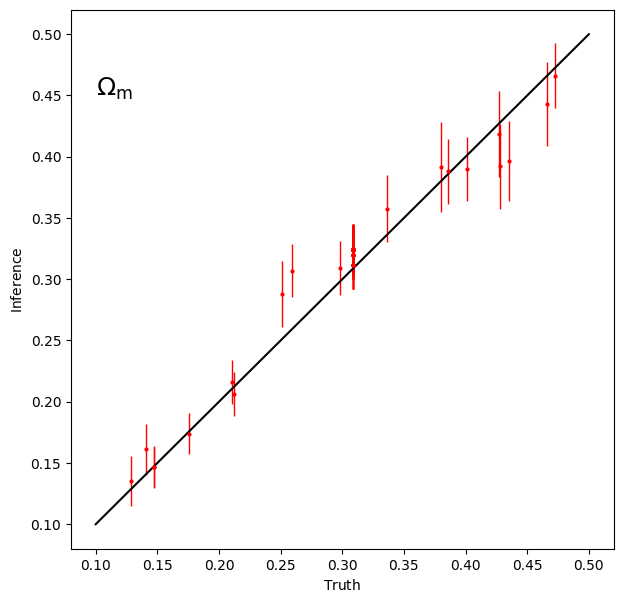

In [18]:
# select the first map of every simulation in the test set
indexes = np.arange(50)*splits

fig=plt.figure(figsize=(7,7))
plt.xlabel(r'${\rm Truth}$')
plt.ylabel(r'${\rm Inference}$')
plt.text(0.1, 0.45, r'$\Omega_{\rm m}$',fontsize=18)


print("R^2:", r2_score(params_true[indexes,0], params_NN[indexes,0]))

plt.errorbar(params_true[indexes,0], params_NN[indexes,0], errors_NN[indexes,0],
             linestyle='None', lw=1, fmt='o', ms=2, elinewidth=1, capsize=0, c='r')
plt.plot([0.1,0.5], [0.1,0.5], color='k')

# plt.title("TNG -> SIMBA")
# plt.savefig("SIMBA_omega_sd.png")
plt.show()

### plot the results for $\sigma_8$

R^2: 0.8328903987375611


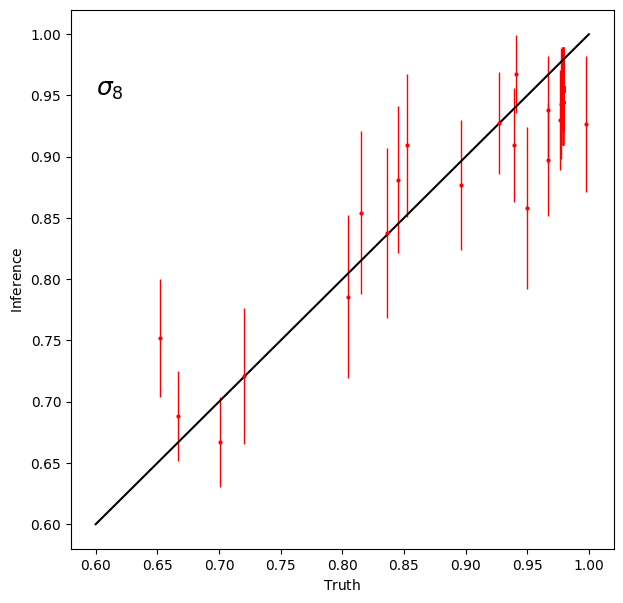

In [19]:
fig=plt.figure(figsize=(7,7))
plt.xlabel(r'${\rm Truth}$')
plt.ylabel(r'${\rm Inference}$')
plt.text(0.6, 0.95, r'$\sigma_8$',fontsize=18)

print("R^2:", r2_score(params_true[indexes,1], params_NN[indexes,1]))

plt.errorbar(params_true[indexes,1], params_NN[indexes,1], errors_NN[indexes,1],
             linestyle='None', lw=1, fmt='o', ms=2, elinewidth=1, capsize=0, c='r')
plt.plot([0.6,1.0], [0.6,1.0], color='k')

# plt.title("TNG -> SIMBA")
# plt.savefig("SIMBA_sigma_sd.png")
plt.show()

### plot results for $A_{\rm SN1}$

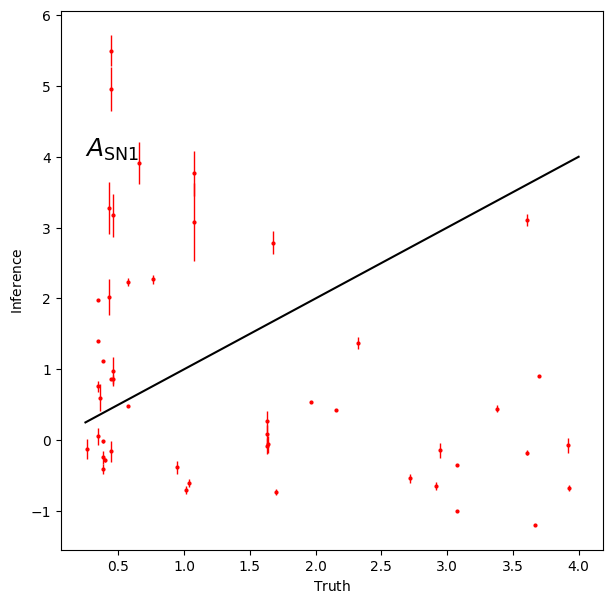

In [21]:
fig=plt.figure(figsize=(7,7))
plt.xlabel(r'${\rm Truth}$')
plt.ylabel(r'${\rm Inference}$')
plt.text(0.25, 4.0, r'$A_{\rm SN1}$',fontsize=18)

plt.errorbar(params_true[indexes,2], params_NN[indexes,2], errors_NN[indexes,2],
             linestyle='None', lw=1, fmt='o', ms=2, elinewidth=1, capsize=0, c='r')
plt.plot([0.25,4.0], [0.25,4.0], color='k')

plt.show()

### plot results for $A_{\rm SN2}$

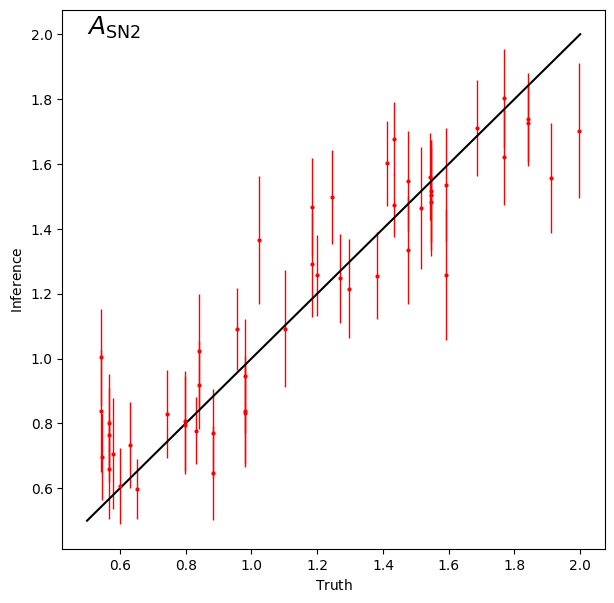

In [20]:
fig=plt.figure(figsize=(7,7))
plt.xlabel(r'${\rm Truth}$')
plt.ylabel(r'${\rm Inference}$')
plt.text(0.5, 2.0, r'$A_{\rm SN2}$',fontsize=18)

plt.errorbar(params_true[indexes,4], params_NN[indexes,4], errors_NN[indexes,4],
             linestyle='None', lw=1, fmt='o', ms=2, elinewidth=1, capsize=0, c='r')
plt.plot([0.5,2.0], [0.5,2.0], color='k')

plt.show()

### plot results for $A_{\rm AGN1}$

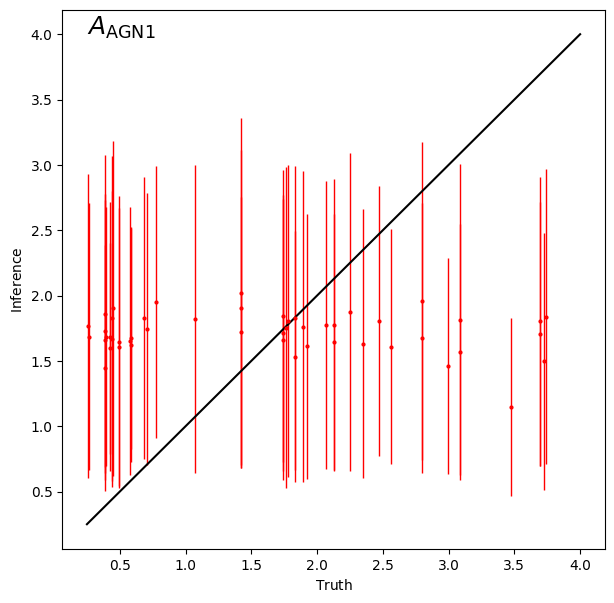

In [21]:
fig=plt.figure(figsize=(7,7))
plt.xlabel(r'${\rm Truth}$')
plt.ylabel(r'${\rm Inference}$')
plt.text(0.25, 4.0, r'$A_{\rm AGN1}$',fontsize=18)

plt.errorbar(params_true[indexes,3], params_NN[indexes,3], errors_NN[indexes,3],
             linestyle='None', lw=1, fmt='o', ms=2, elinewidth=1, capsize=0, c='r')
plt.plot([0.25,4.0], [0.25,4.0], color='k')

plt.show()

### plot results for $A_{\rm AGN2}$

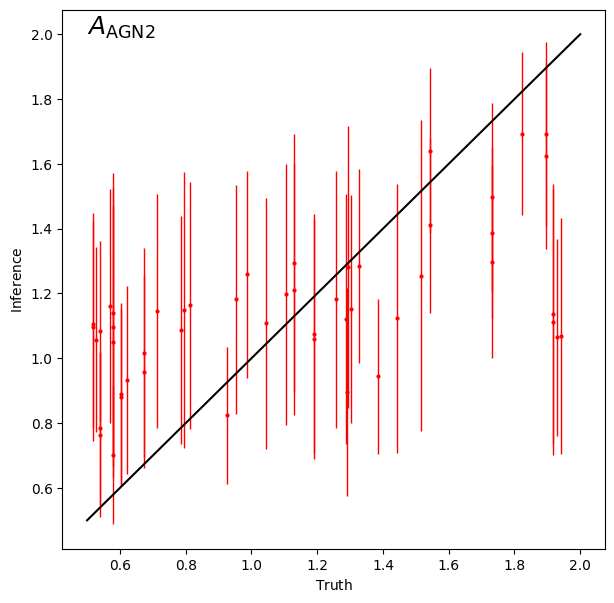

In [22]:
fig=plt.figure(figsize=(7,7))
plt.xlabel(r'${\rm Truth}$')
plt.ylabel(r'${\rm Inference}$')
plt.text(0.5, 2.0, r'$A_{\rm AGN2}$',fontsize=18)

plt.errorbar(params_true[indexes,5], params_NN[indexes,5], errors_NN[indexes,5],
             linestyle='None', lw=1, fmt='o', ms=2, elinewidth=1, capsize=0, c='r')
plt.plot([0.5,2.0], [0.5,2.0], color='k')

plt.show()

## Compute CKA

In [32]:
# now that architecture is defined above, use it
model = model_o3_err_1param(hidden, dr, channels)
# model = nn.DataParallel(model)
model.to(device=device)
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

# load the weights in case they exists
fmodel = 'layer20_TNG_1param_norm/weights.pt'
# fmodel = 'layer20_TNG_SIMBA/weights.pt'
# fmodel = 'best_weights_T_TNG.pt'

if os.path.exists(fmodel):
    checkpoint = torch.load(fmodel, map_location=torch.device(device))
    new_state_dict = {k.replace('module.', ''): v for k, v in checkpoint.items()}
    model.load_state_dict(new_state_dict)
    
    # model.load_state_dict(torch.load(fmodel, map_location=torch.device(device)))
    print('Weights loaded')

total number of parameters in the model = 28429326
Weights loaded


In [44]:
# load test set
fmaps = ['maps_T_TNG.npy']
fparams = '2D_maps/data/params_LH_IllustrisTNG.txt'
test_loader  = create_dataset_multifield('test', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                         rot_flip_in_mem=False, verbose=True)

750
Found 1 channels
Reading data...
1.502e+03 < F(all|orig) < 8.669e+07
3.177 < F(all|resc)  < 7.938
-2.020 < F(all|norm) < 1.917


In [38]:
# load test set
fmaps = ['maps_T_SIMBA.npy']
fparams = '2D_maps/data/params_LH_SIMBA.txt'
test_loader  = create_dataset_multifield('test', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                         rot_flip_in_mem=False, verbose=True)

750
Found 1 channels
Reading data...
2.215e+02 < F(all|orig) < 2.772e+11
2.345 < F(all|resc)  < 11.443
-2.708 < F(all|norm) < 4.815


In [39]:
from similarity.efficient_CKA import *
import matplotlib.pyplot as plt

In [40]:
def normalize_activations(act):
    """Normalize along each row so that the norm of activations produced by each example is 1."""
    act = act.view(act.size(0), -1)
    act_norm = torch.linalg.norm(act, dim=1, keepdim=True)
    act /= act_norm
    return act

def get_activations(images, model, normalize_act=False):
    """Return a list of activations obtained from a model on a set of images."""
    activations = []

    def hook_fn(module, input, output):
        if normalize_act:
            output = normalize_activations(output)
        activations.append(output)

    hooks = []
    for layer in model.children():
        if 'Linear' in str(layer) or 'Conv2d' in str(layer):
            hooks.append(layer.register_forward_hook(hook_fn))

    with torch.no_grad():
        model(images)

    for hook in hooks:
        hook.remove()

    return activations

# Plotting the heatmap with 'magma' colormap and flipping the matrix vertically
def plotHeatmap(heatmap, modelName):
    # plt.imshow(np.flipud(heatmap), cmap='magma', interpolation='nearest')
    imshowobj = plt.imshow(np.flipud(heatmap), cmap='magma', interpolation='nearest')
    # imshowobj.set_clim(0,1)
    plt.colorbar()
    plt.title('CKA$_{minibatch}$'+f' - {modelName}', fontsize=20)
    plt.xlabel('Layer', fontsize=20)
    plt.ylabel('Layer', fontsize=20)
    plt.xticks(ticks=np.arange(1, heatmap.shape[1], 2), labels=[f"{i+1}" for i in range(1, heatmap.shape[1], 2)], fontsize=12)
    plt.yticks(ticks=np.arange(0, heatmap.shape[0], 2), labels=[f"{i+1}" for i in range(heatmap.shape[0]-1, -1, -2)], fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.savefig(f"heatmap/Heatmap_{modelName}.png", dpi=300)
    # files.download(f"Heatmap_{modelName}.png")
    plt.show()

In [45]:
model = model.to('cpu')
model.eval()
# n_layers = len(model.layers)
n_layers = 21
cka = MinibatchCKA(n_layers)
count = 0
iteration = 10
for i in tqdm(range(iteration)):
    for data, target in tqdm(test_loader):
        act = get_activations(data, model, False)
        # print(len(act))
        cka.update_state(act)
        # print(len(data))
        count += len(data)

100%|██████████| 10/10 [03:46<00:00, 22.64s/it]


In [46]:
heatmap = cka.result().numpy()
# eigenvalues, eigenvectors = np.linalg.eig(heatmap)
# np.save("heatmap/Layer21_SIMBA(TNG+SIMBA).npy", heatmap)

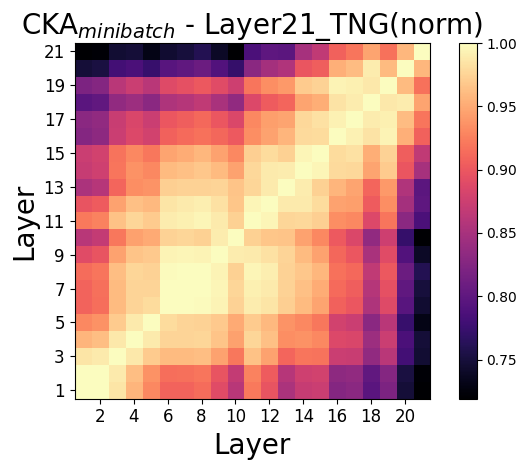

In [47]:
name = 'Layer21_TNG(norm)'
# heatmap = np.load("heatmap/{}.npy".format(name))
plotHeatmap(heatmap, name) # accuracy 99.12%
np.save("heatmap/Layer21_TNG(norm).npy", heatmap)